# OneVsAll - Multiclass logistic regression

In this problem, we will use the same dataset as [before](http://localhost:8888/notebooks/OneDrive/Genetic%20Programming/notebooks/3.%20Logistic%20Regression%20-%20Binary%20Classification.ipynb) - [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), however without removing one of the flower species that makes the problem multiclass logistic regression.

The whole precedure will be very similar, however now we will do multiple binary classifications and for each class predict whether the observations are in that class. The final solution will be the max of probability of each classes, as spitted out by our classifier.

### Once again, let's start with some data analysis and preprocessing

In [1]:
import math
import sys
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
iris = pd.read_csv('./../datasets/IRIS.csv')

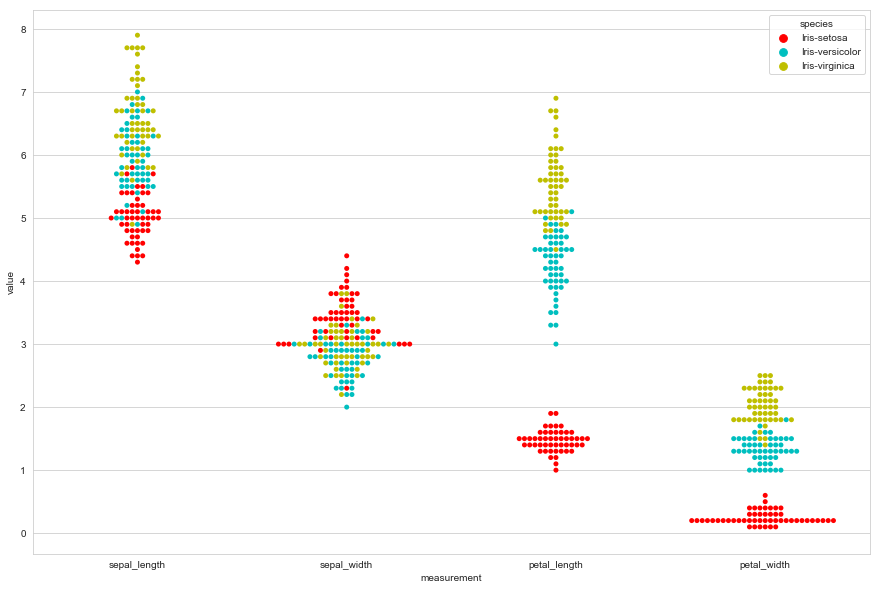

In [3]:
ax = pd.melt(iris, 'species', var_name='measurement')

plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")
sns.swarmplot(x='measurement', y='value', hue='species',
              palette=['r', 'c', 'y'], data=ax)

In [4]:
# Use standard scaling on the rest of the features
std = iris.drop(['species'], axis=1).std()
mean = iris.drop(['species'], axis=1).mean()

for column in iris.drop(['species'], axis=1).columns:
    iris[column] = iris[column].apply(lambda x: (x-mean[column])/std[column])

# Shuffle the dataset
iris = iris.sample(frac=1)

In [5]:
# Get inputs and labels - add bias term as first input
inputs = iris.drop('species', axis=1).values
inputs = np.hstack([np.ones([inputs.shape[0], 1]), inputs])

In [6]:
labels = pd.get_dummies(iris['species'])

In [7]:
inputs[:5]

array([[ 1.        ,  1.51759216, -0.12454038,  1.21361854,  1.18105307],
       [ 1.        ,  0.55148575, -0.81643138,  0.64686019,  0.78795108],
       [ 1.        ,  0.30995914, -0.35517071,  0.53350852,  0.26381511],
       [ 1.        , -0.65614727,  1.48987194, -1.28011819, -1.30859282],
       [ 1.        , -0.89767388, -1.27769204, -0.42998067, -0.12928687]])

In [8]:
labels.head()

,Iris-setosa,Iris-versicolor,Iris-virginica
102,0,0,1
123,0,0,1
63,0,1,0
48,1,0,0
98,0,1,0


### Evolution functions

I'll just copy and paste the functions from the previous notebook I've written - feel free to have a look (here)[http://localhost:8888/notebooks/OneDrive/Genetic%20Programming/notebooks/3.%20Logistic%20Regression%20-%20Binary%20Classification.ipynb] if you're interested in more details.

In [9]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [10]:
def fitness(weights, inputs, labels, _lambda=.1):
    num_observations = inputs.shape[0]
    predictions = sigmoid(np.dot(weights, inputs.T))
    
    cost = -np.average(labels*np.log(predictions) + (1-labels)*np.log(1-predictions), axis=1)
    cost = np.nan_to_num(cost)
    
    return cost

In [11]:
def select_parents(population, most_fitted, num_parents, lucky_parent):
    sorts = most_fitted.argsort() # Get indices according to sorted ascending fitness costs
    
    parents = np.empty(num_parents)
    for i in range(num_parents[0]):
        if random.random() >= lucky_parent:
            parents[i, :] = population[sorts[i]]
        else:
            parents[i, :] = population[random.choice(sorts)]
            
    # np.random.shuffle(parents)
    return parents

In [12]:
def crossover(parents, num_offsprings, num_weights):
    find_crossover_point = lambda x: math.floor(x) if random.random() < .5 else math.ceil(x)
    
    offsprings = np.empty(num_offsprings)
    for i in range(num_offsprings[0]):
        parent1_idx = i % parents.shape[0]
        parent2_idx = (i+1) % parents.shape[0]
        
        crossover_point = find_crossover_point(num_weights/2)
        offsprings[i, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offsprings[i, crossover_point:] = parents[parent2_idx, crossover_point:]
        
    return offsprings

In [13]:
def mutation(offsprings, mutation_chance):
    for i in range(offsprings.shape[0]):
        for j in range(offsprings.shape[1]):
            if random.random() < mutation_chance:
                offsprings[i, j] += np.random.uniform(-1, 1)
                
    return offsprings

### Evolution process

Split the dataset into train and test set:

In [14]:
X_train = inputs[:125]
X_test = labels[:125]

y_train = inputs[125:]
y_test = labels[125:]

 Set the hyperparemeters:

In [62]:
NUM_INDIVIDUALS = 15
NUM_WEIGHTS = inputs.shape[1]
POPULATION_SIZE = (NUM_INDIVIDUALS, NUM_WEIGHTS)
NUM_GENERATIONS = 151

LUCKY_PARENT = .15
MUTATION_CHANCE = .10
NUM_PARENTS = (8, NUM_WEIGHTS)
NUM_OFFSPRINGS = (NUM_INDIVIDUALS-NUM_PARENTS[0], NUM_WEIGHTS)

Define the evolution function that will be used to train each of the classifiers:

In [63]:
def run_evolution(X_train, X_test):
    history = []
    population = np.random.uniform(-1, 1, POPULATION_SIZE)

    for generation in range(NUM_GENERATIONS):
        most_fitted = fitness(population, X_train, X_test)

        best_fitted_idx = np.where(fitness == np.min(fitness))
        best_weights = population[best_fitted_idx]
        best_score = np.min(most_fitted)
        history.append((generation, best_score, best_weights))

        if generation % 25 == 0:
            print('At generation #{}, cost function is: {}'.format(generation, best_score))

        parents = select_parents(population, most_fitted, NUM_PARENTS, LUCKY_PARENT)
        offsprings = crossover(parents, NUM_OFFSPRINGS, NUM_WEIGHTS)
        mutated_offsprings = mutation(offsprings, MUTATION_CHANCE)

        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = mutated_offsprings
        
    return history

And now the fun begins - we are going to train 3 different binary classifiers, each to classify its respective flower species. 

In [64]:
results = {}
for species in labels.columns:
    print('Running evolution for {}:'.format(species))
    results[species] = run_evolution(X_train, np.array(X_test[species]))
    print('...Completed!')
    print('-'*50)

Running evolution for Iris-setosa:
At generation #0, cost function is: 0.20786294018222776
At generation #25, cost function is: 0.013954755386458023
At generation #50, cost function is: 0.0019057110062979403
At generation #75, cost function is: 0.0006302823187492193
At generation #100, cost function is: 0.0002545422263674639
At generation #125, cost function is: 0.00010837051881051534
At generation #150, cost function is: 3.2807032119194e-05
...Completed!
--------------------------------------------------
Running evolution for Iris-versicolor:
At generation #0, cost function is: 0.6003665555812266
At generation #25, cost function is: 0.52153072323704
At generation #50, cost function is: 0.5133394550168309
At generation #75, cost function is: 0.5133394550168309
At generation #100, cost function is: 0.5120214260064541
At generation #125, cost function is: 0.5127587276371607
At generation #150, cost function is: 0.5126264580277636
...Completed!
--------------------------------------------

### Vizualize and analyse the results

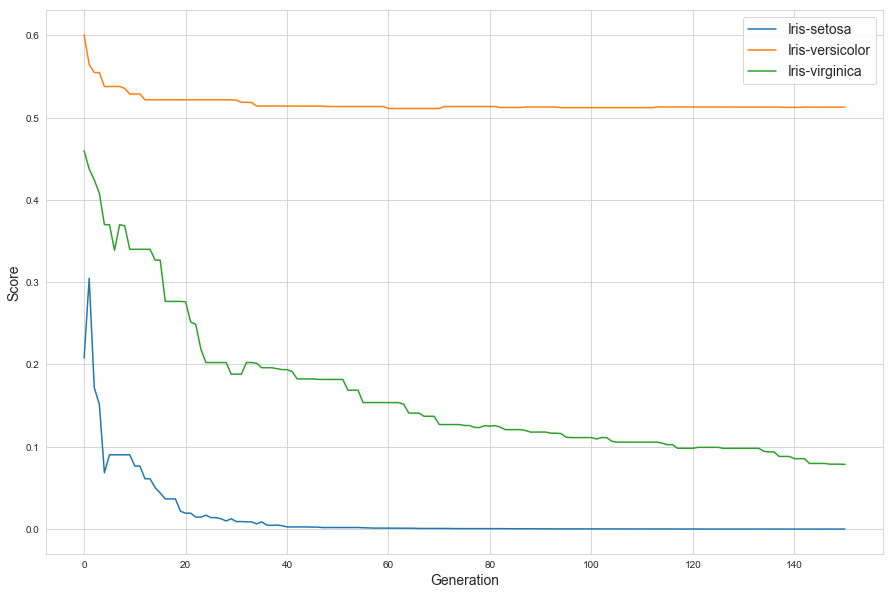

In [65]:
ax = plt.figure(figsize=(15, 10))
ax2 = plt.axes()

for species in labels.columns:
    generation, score, weights = zip(*results[species])
    sns.lineplot(generation, score)

plt.legend(labels.columns, loc='upper right', fontsize=14)
ax2.set_xlabel('Generation', fontsize=14)
ax2.set_ylabel('Score', fontsize=14)
plt.show()

It appears that the cross-entropy hasn't reduced much, especially for versicolor. Let's see how it turns out in the accuracy metrics.

In [66]:
def get_predictions(weights, inputs):
    predictions = sigmoid(np.dot(weights, inputs.T))
    return np.where(predictions > .5, 1, 0)

def get_accuracy(predictions, real_labels):
    return (real_labels.reset_index(drop=True) == predictions).all(1).mean()

In [67]:
train_results = pd.DataFrame()
test_results = pd.DataFrame()

for species in labels.columns:
    generation, score, weights = zip(*results[species])
    best_weights = weights[-1]
    
    train_preds = get_predictions(best_weights, X_train)
    train_results[species] = pd.Series(train_preds[0])
    
    test_preds = get_predictions(best_weights, y_train)
    test_results[species] = pd.Series(test_preds[0])

In [68]:
train_acc = get_accuracy(train_results, X_test)
print('Accuracy on training set is {}.'.format(train_acc))

Accuracy on training set is 0.712.


In [69]:
test_acc = get_accuracy(test_results, y_test)
print('Accuracy on a test set is {}.'.format(test_acc))

Accuracy on a test set is 0.76.


### Done!

Ok, that was far from perfect, only 76% accuracy on a test score, and rather low ~72% accuracy on the training data! Next time, let's add some more breeding and mutation function (or change fitness to something else?) to see if we can get at least 90%+